In [1]:
import torchvision.transforms.functional as T
import torch
from torchvision.ops import masks_to_boxes
from torchvision.ops import nms
from torchvision.ops.boxes import box_iou
from groundingdino.util.inference import load_model, load_image
from groundingdino.util.inference import predict as predict_gd
import clip
from tqdm import tqdm
import linecache
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm


import cv2
import gc
import os
import copy
import sys
import re
from PIL import Image

from scipy.optimize import linear_sum_assignment
from sklearn.metrics.pairwise import cosine_similarity
from torch.distributions import kl_divergence
from torch.distributions.categorical import Categorical


# ######################### muSSP import #################################
import mot3d
import mot3d.weight_functions as wf
from mot3d.utils import utils
# ########################################################################

import warnings

warnings.filterwarnings("ignore")

gc.collect()

0

In [2]:
a = {"c": 1, "d": 2}
np.array(list(a.items()))

array([['c', '1'],
       ['d', '2']], dtype='<U21')

In [3]:
# Get GD
from segment_anything import sam_model_registry, SamPredictor
gd_model = load_model(
    "../GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py",
    "../GroundingDINO/weights/groundingdino_swinb_cogcoor.pth")

# Get SAM
sam_checkpoint = "/home/jash/Desktop/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

sam_predictor = SamPredictor(sam)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Helper functions

In [4]:
def rle_to_mask(rle, shape):
    mask = np.zeros(shape[0] * shape[1], dtype=bool)
    current_pos = 0
    for idx, length in enumerate(rle):
        color = idx % 2 == 1
        mask[current_pos: current_pos + length] = color
        current_pos += length
    return mask.reshape(shape)


def get_multiple_boolean_masks(example_name, image_shape, frame=1):
    masks = []
    folder_path = '/home/jash/Desktop/vot_workplace/sequences/' + example_name
    ground_truth_files = [f for f in os.listdir(
        folder_path) if f.startswith('groundtruth') and f.endswith('.txt')]

    for gt_file in ground_truth_files:
        gt_file_path = os.path.join(folder_path, gt_file)
        mask_str = linecache.getline(gt_file_path, frame).strip('\n')

        # Parse the mask string
        values = [int(val) for val in mask_str[1:].split(',')]
        offset_x, offset_y, region_width, region_height = values[:4]
        rle_values = values[4:]

        # Convert the RLE to a boolean mask
        region_mask = rle_to_mask(rle_values, (region_height, region_width))

        # Create a full-sized boolean mask with the region mask at the correct
        # offset
        boolean_mask = np.zeros(image_shape, dtype=bool)
        boolean_mask[offset_y: offset_y + region_height,
                     offset_x: offset_x + region_width] = region_mask

        masks.append(boolean_mask)

    return masks


def boolean_mask_to_bbox(boolean_mask):

    # Check if mask is int8 if not convert it
    boolean_mask = torch.tensor(boolean_mask)

    if boolean_mask.dtype != torch.uint8:
        binary_mask = boolean_mask.to(torch.uint8)
    else:
        binary_mask = boolean_mask

    # Add an extra dimension to binary_mask to match the expected input shape
    # for masks_to_boxes
    binary_mask = binary_mask.unsqueeze(0)
    # Compute the bounding box
    bbox = masks_to_boxes(binary_mask)

    return bbox.squeeze(0)


def get_crop(img, obj_dimensions=None, scale=1):
    """Given top left cooridnate and height and width of the crop,
    it returns a squared version of the crop and scales it, if required.

    Args:
        example_name (string): Name of the example from the VOT dataset.
        scale (int, optional): Parameter to scale square size. Defaults to 1.
        Can't be set to 0.

    """
    if scale == 0:
        raise ValueError("Scale must be > 0")

    def _resized_square(x, y, h, w, scale=1):
        """
         Args:
            x (float): Horizontal component of the top left corner of the crop box.
            y (float): Vertical component of the top left corner of the crop box.
            h (float): Height of the crop box.
            w (float): Width of the crop box.
            scale (int, optional): Parameter to scale square size. Defaults to 1.
            Can't be set to 0.

        """
        midx, midy = (2 * x + w) // 2, (2 * y + h) // 2
        new_square_len = max(w, h) * scale
        x = midx - new_square_len // 2
        y = midy - new_square_len // 2
        w = h = new_square_len
        return x, y, h, w

    # User defined obj dimensions
    obj_x, obj_y, obj_h, obj_w = np.array(
        [obj_dimensions[0],
         obj_dimensions[1],
         obj_dimensions[3] - obj_dimensions[1],
         obj_dimensions[2] - obj_dimensions[0]])

    # Changes top left coordinates, h and w of ground truth and scales the
    # square.
    resized_x, resized_y, resized_h, resized_w = _resized_square(
        obj_x, obj_y, obj_h, obj_w, scale=scale)
    # Crops image with given parameters
    cropped_image = T.crop(Image.fromarray(np.uint8(img)), int(resized_y), int(
        resized_x), int(resized_h), int(resized_w))

    return cropped_image


def get_bbox_iou(box, boxes):
    boxes1 = np.array(box).reshape(1, 4)
    boxes2 = np.array(boxes)

    x11, y11, x12, y12 = np.split(boxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(boxes2, 4, axis=1)

    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))

    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)

    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou


def boxes_distance(boxA, boxB):
    # boxA and boxB are tuples in the format (x1, y1, x2, y2)

    A_min = np.array(boxA[:2])  # x1, y1
    A_max = np.array(boxA[2:])  # x2, y2
    B_min = np.array(boxB[:2])  # x1, y1
    B_max = np.array(boxB[2:])  # x2, y2

    delta1 = A_min - B_min  # difference between left/top
    delta2 = A_max - B_max  # difference between right/bottom
    dist = np.sum(np.abs(np.concatenate([delta1, delta2])))

    return dist


def linear_assignment(cost_matrix):
    """
    Hungarian algorithm for solving assignment problem.
    """
    # try:
    #     _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
    #     valid_assignments = x != -1
    #     return np.arange(len(x))[valid_assignments], x[valid_assignments]
    # except BaseException:
    x, y = linear_sum_assignment(cost_matrix)
    return x, y


def get_indices_with_low_kl_div(single_prob_dist, prob_dist_array, threshold):
    """
    Given a single probability distribution, an array of probability distributions,
    and a threshold, compute the KL divergence between the single distribution
    and each distribution in the array, and return the indices of those whose
    KL divergence is lower than the threshold.

    Args:
    single_prob_dist (torch.Tensor): Single probability distribution of shape [n,].
    prob_dist_array (torch.Tensor): Array of probability distributions of shape [m, n].
    threshold (float): KL divergence threshold.

    Returns:
    torch.Tensor: Indices of the prob_dist_array whose KL divergence with single_prob_dist is lower than threshold.
    """
    non_zero_indices = torch.nonzero(single_prob_dist, as_tuple=True)[0]

    single_prob_dist = single_prob_dist[non_zero_indices]
    prob_dist_array = prob_dist_array[:, non_zero_indices]

    single_cat = Categorical(single_prob_dist)
    prob_dist_cats = Categorical(prob_dist_array)

    kl_divs = kl_divergence(single_cat, prob_dist_cats)
    low_kl_indices = torch.where(kl_divs < threshold)[0]

    return low_kl_indices.tolist(), kl_divs


def plot_results(img_path, tracked_boxes, sequence, plot_name="", tracked_masks=None):
    plt.figure(figsize=(10, 10))
    img = cv2.imread(img_path)[:, :, ::-1]
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{plot_name}:: Sequence: {sequence}, Frame: {img_path.split('/')[-1]}")

    ax = plt.gca()

    colours = [cm.viridis(i/len(tracked_boxes))[:-1] for i in range(len(tracked_boxes))]
    for object_id, bbox in tracked_boxes:
        x1, y1, x2, y2 = bbox
        ax.add_patch(
            plt.Rectangle(
                (x1,
                 y1),
                x2 - x1,
                y2 - y1,
                fill=False,
                color=colours[object_id],
                linewidth=3))
        ax.text(x1, y1 - 2, f"ID: {object_id}", color='r', fontsize=12)

    if tracked_masks is not None:
        for object_id, mask in tracked_masks:
            mask = mask.squeeze()
            # Overlay the mask on the image
            ax.imshow(
                np.ma.masked_where(
                    mask == 0,
                    mask),
                alpha=0.5,
                cmap='jet',
                interpolation='none')

    # Create folder if folder does not exist
    if not os.path.exists(f"{plot_name}_results/{sequence}"):
        os.makedirs(f"{plot_name}_results/{sequence}")
    plt.savefig(f"{plot_name}_results/{sequence}/{img_path.split('/')[-1]}")
    plt.close()

def debug_plot(image_n, sequence, img_path, detection_bboxes, prev_predicted_boxes):
    # Plot prev predicted boxes in green and detection boxes in red on same
    # image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_n)
    red_patch = patches.Patch(color='red', label='GD detections')
    green_patch = patches.Patch(color='green', label='prev predicted')
    plt.legend(handles=[red_patch, green_patch])

    plt.title(f"Sequence: {sequence}, Frame: {img_path.split('/')[-1]}")
    for bbox in prev_predicted_boxes:
        x1, y1, x2, y2 = bbox
        plt.gca().add_patch(
            plt.Rectangle(
                (x1,
                 y1),
                x2 - x1,
                y2 - y1,
                fill=False,
                color='g',
                linewidth=3))
    for i, bbox in enumerate(detection_bboxes):
        x1, y1, x2, y2 = bbox
        plt.gca().add_patch(
            plt.Rectangle(
                (x1,
                 y1),
                x2 - x1,
                y2 - y1,
                fill=False,
                color='r',
                linewidth=1))
        plt.text(x1, y1 - 2, f"ID:{i}", color='r', fontsize=10)

    # Create folder
    if not os.path.exists(f"debug/{sequence}"):
        os.makedirs(f"debug/{sequence}")
    plt.savefig(f"debug/{sequence}/tracked_{img_path.split('/')[-1]}")
    plt.close()

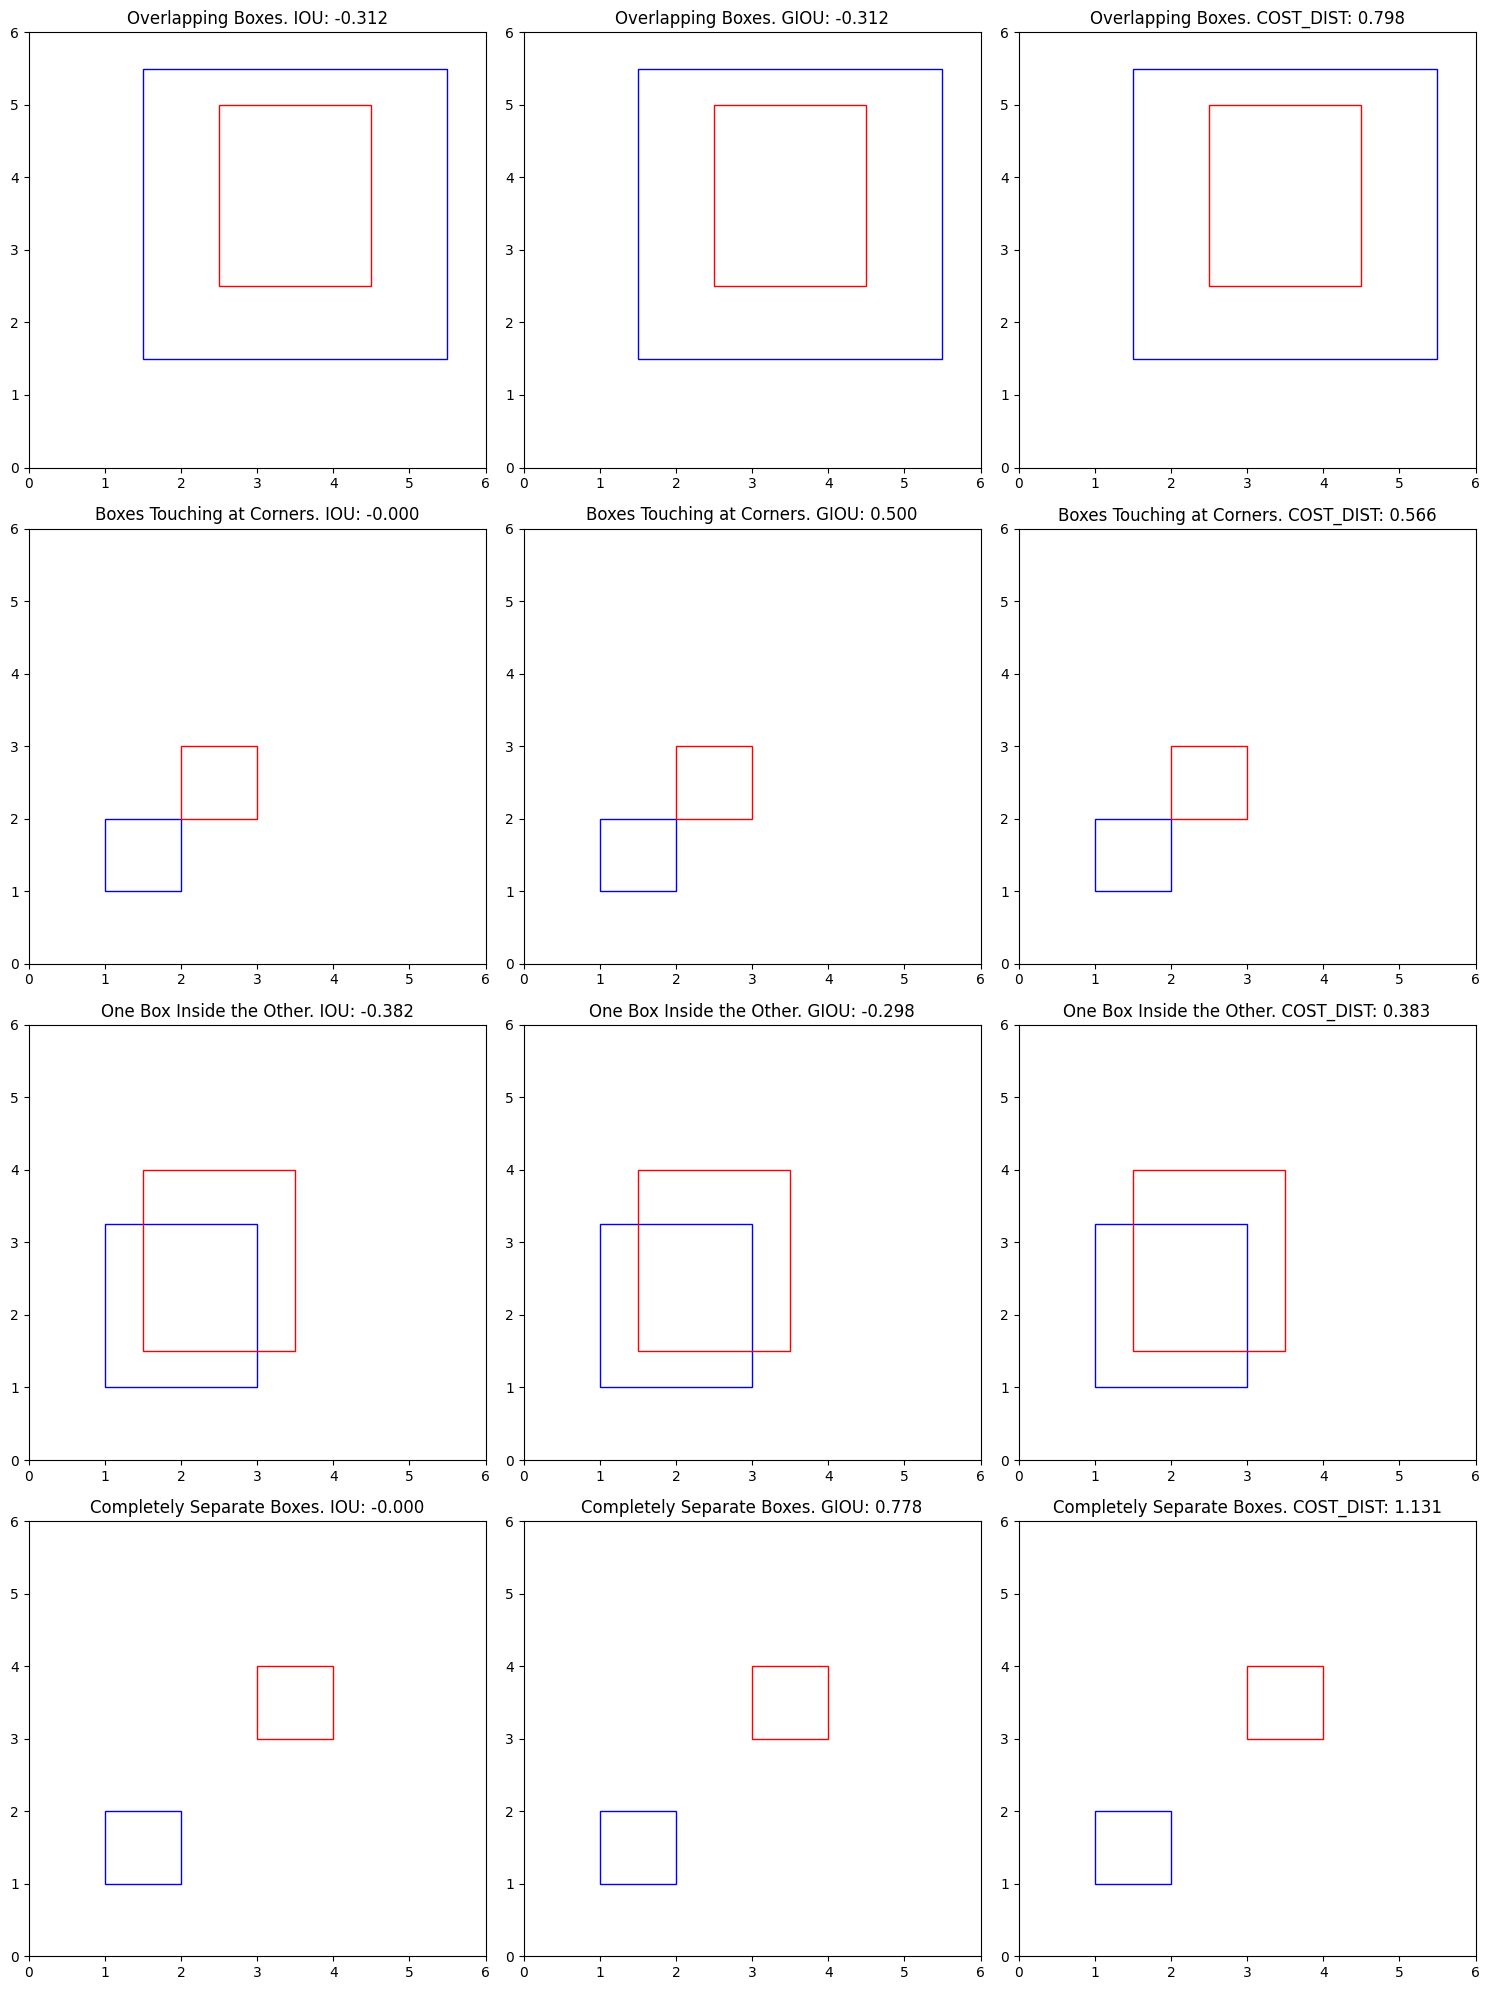

In [5]:
def calculate_giou(boxes1, boxes2):
    """Computes the Generalized Intersection over Union (GIOU) between two lists of boxes.
    boxes1 and boxes2 are 2D Tensors of size (N, 4) containing boxes in (xmin, ymin, xmax, ymax) format.
    Returns a 1D tensor with one GIoU per pair of boxes.
    """
    # Calculate intersection area
    inter_xmin = torch.max(boxes1[:, 0], boxes2[:, 0])
    inter_ymin = torch.max(boxes1[:, 1], boxes2[:, 1])
    inter_xmax = torch.min(boxes1[:, 2], boxes2[:, 2])
    inter_ymax = torch.min(boxes1[:, 3], boxes2[:, 3])
    inter_area = (
        inter_xmax - inter_xmin).clamp(0) * (inter_ymax - inter_ymin).clamp(0)

    # Calculate area of each box
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Calculate union area
    union_area = area1 + area2 - inter_area

    # Calculate IoU
    iou = inter_area / union_area

    # Calculate the minimal enclosing box area
    enc_xmin = torch.min(boxes1[:, 0], boxes2[:, 0])
    enc_ymin = torch.min(boxes1[:, 1], boxes2[:, 1])
    enc_xmax = torch.max(boxes1[:, 2], boxes2[:, 2])
    enc_ymax = torch.max(boxes1[:, 3], boxes2[:, 3])
    enc_area = (enc_xmax - enc_xmin) * (enc_ymax - enc_ymin)

    # Calculate GIoU
    giou = iou - (enc_area - union_area) / enc_area

    return giou


def calculate_cost_dist(boxes1, boxes2, alpha=0.6):
    # Calculate center of each box
    center1 = ((boxes1[:, 0] + boxes1[:, 2]) / 2,
               (boxes1[:, 1] + boxes1[:, 3]) / 2)
    center2 = ((boxes2[:, 0] + boxes2[:, 2]) / 2,
               (boxes2[:, 1] + boxes2[:, 3]) / 2)

    # Calculate L2 distance between centers
    l2_dist = torch.sqrt((center1[0] - center2[0])
                         ** 2 + (center1[1] - center2[1]) ** 2)

    # Calculate area of each box
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Compute difference in log areas
    log_area_diff = torch.abs(torch.log(area1) - torch.log(area2))

    # Calculate cost_dist
    cost_dist = (1 - alpha) * l2_dist + alpha * log_area_diff

    return cost_dist


box_list = [
    ((1.5, 1.5, 5.5, 5.5), (2.5, 2.5, 4.5, 5), 'Overlapping Boxes'),
    ((1, 1, 2, 2), (2, 2, 3, 3), 'Boxes Touching at Corners'),
    ((1, 1, 3, 3.25), (1.5, 1.5, 3.5, 4), 'One Box Inside the Other'),
    ((1, 1, 2, 2), (3, 3, 4, 4), 'Completely Separate Boxes')
]


def plot_boxes(ax, boxA, boxB, title, method):
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 6)

    rectA = patches.Rectangle(
        (boxA[0],
         boxA[1]),
        boxA[2] - boxA[0],
        boxA[3] - boxA[1],
        edgecolor='blue',
        facecolor="none")
    rectB = patches.Rectangle(
        (boxB[0],
         boxB[1]),
        boxB[2] - boxB[0],
        boxB[3] - boxB[1],
        edgecolor='red',
        facecolor="none")

    ax.add_patch(rectA)
    ax.add_patch(rectB)

    if method == 'iou':
        score = -(box_iou(torch.tensor([boxA]), torch.tensor([boxB])).item())
    elif method == 'giou':
        score = -(
            calculate_giou(
                torch.tensor(
                    [boxA]), torch.tensor(
                    [boxB])).item())
    elif method == 'cost_dist':
        score = calculate_cost_dist(
            torch.tensor(
                [boxA]), torch.tensor(
                [boxB])).item()

    ax.set_title(f'{title}. {method.upper()}: {score:.3f}')


fig, axs = plt.subplots(4, 3, figsize=(15, 20))

for i, (boxA, boxB, title) in enumerate(box_list):
    plot_boxes(axs[i, 0], boxA, boxB, title, 'iou')
    plot_boxes(axs[i, 1], boxA, boxB, title, 'giou')
    plot_boxes(axs[i, 2], boxA, boxB, title, 'cost_dist')

plt.tight_layout()
plt.show()

## SAM setup

In [6]:
def box_to_seg(image, boxes):
    sam_predictor.set_image(image)

    input_boxes = torch.tensor(boxes, device=sam_predictor.device)
    transformed_boxes = sam_predictor.transform.apply_boxes_torch(
        input_boxes, image.shape[: 2])
    masks, mask_quality, _ = sam_predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=True
    )
    # masks has shape (n, 3, w, h), where n is the number of objects, 3 is the number of masks for each box, and w, h are the width and height of the image.
    # mask_quality has shape (n, 3), where n is the number of objects, and 3 is the number of masks for each box.
    # Instead of returning all 3 masks, we return the mask with the highest
    # quality.
    best_mask_indices = torch.argmax(mask_quality, dim=1)
    masks = masks[torch.arange(masks.shape[0]), best_mask_indices]

    return masks.squeeze(1).cpu().numpy()


def box_to_seg_2(image, boxes):
    sam_predictor.set_image(image)

    input_boxes = torch.tensor(boxes, device=sam_predictor.device)
    transformed_boxes = sam_predictor.transform.apply_boxes_torch(
        input_boxes, image.shape[: 2])
    masks, _, _ = sam_predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )
    return masks.squeeze(1).cpu().numpy()

In [7]:
# sequence = "f1"
# img_dir = f"/home/jash/Desktop/vot_workplace/sequences/{sequence}/color/"
# img_path_list = sorted([os.path.join(img_dir, img_name)
#                         for img_name in os.listdir(img_dir)
#                         if img_name.endswith('.jpg')])
# image_shape = cv2.imread(img_path_list[0]).shape
# gt_masks = get_multiple_boolean_masks(sequence, image_shape[:2])
# gt_bboxes = [boolean_mask_to_bbox(mask).tolist() for mask in gt_masks]

# seg_masks = box_to_seg(cv2.imread(img_path_list[0])[:, :, ::-1], gt_bboxes)
# # Plotting
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# ax.imshow(cv2.imread(img_path_list[0])[:, :, ::-1])
# for box in gt_bboxes:
#     x1, y1, x2, y2 = box
#     ax.add_patch(
#         patches.Rectangle(
#             (x1,
#              y1),
#             x2 - x1,
#             y2 - y1,
#             fill=False,
#             color='g',
#             linewidth=3))
# for mask in seg_masks:
#     ax.imshow(
#         np.ma.masked_where(
#             mask == 0,
#             mask),
#         alpha=0.5,
#         cmap='jet',
#         interpolation='none')

In [8]:
# Given 2 masks of same shape, write function to calculate the IoU between them
def calculate_mask_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


#  For all sequences in the VOT dataset, calculate the IoU between the ground truth masks and the segmentation masks for first frame.
# Plot mIou scores for each sequence print average mIoU score for all sequences.
# mIoU_scores = []
# sequence_names = []
# for sequence in tqdm(os.listdir("/home/jash/Desktop/vot_workplace/sequences/")):
#     if sequence == "list.txt":
#         continue
#     sequence_names.append(sequence)
#     img_dir = f"/home/jash/Desktop/vot_workplace/sequences/{sequence}/color/00000001.jpg"
#     image_shape = cv2.imread(img_dir).shape
#     gt_masks = get_multiple_boolean_masks(sequence, image_shape[:2])
#     gt_bboxes = [boolean_mask_to_bbox(mask).tolist() for mask in gt_masks]
#     seg_masks = box_to_seg(cv2.imread(img_dir)[:, :, ::-1], gt_bboxes)
#     iou_scores = []
#     for i in range(len(gt_masks)):
#         iou_scores.append(calculate_mask_iou(gt_masks[i], seg_masks[i]))
#     mIoU_scores.append(np.mean(iou_scores))

# fig = plt.figure(figsize=(20, 10))
# plt.bar(sequence_names, mIoU_scores)
# plt.title("mIoU scores for all sequences")
# plt.show()
# print(f"Average mIoU score for all sequences: {np.mean(mIoU_scores)}")

## GD setup

In [9]:

def transform_gd_boxes(boxes, image_shape):
    """
    Transforms the boxes from GD format to x1,y1,x2,y2 format.
    """
    h, w, _ = image_shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h

    return torch.stack((x1, y1, x2, y2), dim=-1).type(torch.int)


custom = "object. wire crossing. frisbee. disk. person. cone. motorcycle.\
 head. insect. animal. sea creature. fish. game character. shape. object in the dark. person in the dark.\
 skateboard. bag. plastic. white thing. black thing. crab. bird. sports person. two wheeler. penguin. boat. book. bottle.\
 vehicle. reptile. hat. shoe. ball. object in focus. object in center. human. flying object. flag. \
 head of object. hand of human. kite. leaf. car. licenseplate. machine. robot. equipment. part. umbrella."


def detect_objects(
        img_path,
        box_threshold=0.08,
        text_threshold=0.25,
        caption=custom):

    _, image = load_image(img_path)

    boxes, box_scores, _, all_logits = predict_gd(
        model=gd_model,
        image=image,
        caption=caption,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )
    return boxes, box_scores, all_logits


def get_gt_prob_dist(bbox, frame_1_detections, frame_1_logits):
    """
    Get gt prob distribution by taking max iou between 1st frame gt
    box and 1st frame detections.
    Return the prob distribution of the box with max iou.

    """
    iou_values = get_bbox_iou(bbox, frame_1_detections)
    max_iou_index = np.argmax(iou_values)
    return frame_1_logits[max_iou_index], max_iou_index

## Custom Tracker setup

In [10]:
def linear_assignment(cost_matrix):
    """
    Hungarian algorithm for solving assignment problem.
    """
    # try:
    #     _, x, y = lap.lapjv(cost_matrix, extend_cost=True)
    #     valid_assignments = x != -1
    #     return np.arange(len(x))[valid_assignments], x[valid_assignments]
    # except BaseException:
    x, y = linear_sum_assignment(cost_matrix)
    return x, y


def KL_filter(detection_prob_distributions, kl_threshold=0.3):

    global trackers  # Use the global trackers dictionary
    # For each track, we will compute the KL divergence between the track's
    # p_gt and detection_prob_distributions.

    detections_sim_for_each_track = []
    KL_matrix = []
    # Iterate only non-distractors
    for track in trackers.values():
        top_div, all_div = get_indices_with_low_kl_div(
            track['prob_dist'], detection_prob_distributions, kl_threshold)
        detections_sim_for_each_track.append(top_div)
        KL_matrix.append(all_div.tolist())
    # The union of all the indices.
    unioned_indices = list(set().union(*detections_sim_for_each_track))
    # Filtering the KL matrix to only contain the unioned indices.
    KL_matrix = np.array(KL_matrix)
    unioned_matrix = KL_matrix[np.arange(KL_matrix.shape[0])[
        :, None], unioned_indices]

    return unioned_indices, unioned_matrix


def iou(bb_test, bb_gt):
    """
    From SORT: Computes IOU between two bboxes in the form [x1,y1,x2,y2]
    """
    bb_gt = np.expand_dims(bb_gt, 0)
    bb_test = np.expand_dims(bb_test, 1)

    xx1 = np.maximum(bb_test[..., 0], bb_gt[..., 0])
    yy1 = np.maximum(bb_test[..., 1], bb_gt[..., 1])
    xx2 = np.minimum(bb_test[..., 2], bb_gt[..., 2])
    yy2 = np.minimum(bb_test[..., 3], bb_gt[..., 3])
    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)
    wh = w * h
    o = wh / ((bb_test[...,
                       2] - bb_test[...,
                                    0]) * (bb_test[...,
                                                   3] - bb_test[...,
                                                                1]) + (bb_gt[...,
                                                                             2] - bb_gt[...,
                                                                                        0]) * (bb_gt[...,
                                                                                                     3] - bb_gt[...,
                                                                                                                1]) - wh)
    return -(o)


def custom_cost(boxes1, boxes2, image_shape, alpha=0.5):
    # Calculate center of each box
    center1 = np.column_stack(
        [(boxes1[:, 0] + boxes1[:, 2]) / 2, (boxes1[:, 1] + boxes1[:, 3]) / 2])
    center2 = np.column_stack(
        [(boxes2[:, 0] + boxes2[:, 2]) / 2, (boxes2[:, 1] + boxes2[:, 3]) / 2])

    # Expand dimensions for broadcasting
    center1_exp = np.expand_dims(center1, axis=1)
    center2_exp = np.expand_dims(center2, axis=0)

    # Calculate L2 distance between centers
    l2_dist = np.sqrt(np.sum((center1_exp - center2_exp) ** 2, axis=2))
    # Normalize l2_dist by longest side of the image
    l2_dist = l2_dist / np.max(image_shape)

    # Calculate area of each box
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

    # Expand dimensions for broadcasting
    area1_exp = np.expand_dims(area1, axis=1)
    area2_exp = np.expand_dims(area2, axis=0)

    # Compute difference in log areas
    log_area_diff = np.abs(np.log(area1_exp) - np.log(area2_exp))
    # print(log_area_diff)

    # Calculate cost_dist
    cost_dist = l2_dist + log_area_diff

    # Add penalty for pairs with normalized L2 distance less than 0.1
    cost_dist[l2_dist < 0.1] += 1
    # Add penalty for pairs with log area difference greater than 0.3
    cost_dist[log_area_diff > 0.3] += 1

    return cost_dist


def l2_pairwise(boxes1, boxes2, image_shape):
    # Calculate center of each box
    center1 = np.column_stack(
        [(boxes1[:, 0] + boxes1[:, 2]) / 2, (boxes1[:, 1] + boxes1[:, 3]) / 2])
    center2 = np.column_stack(
        [(boxes2[:, 0] + boxes2[:, 2]) / 2, (boxes2[:, 1] + boxes2[:, 3]) / 2])

    # Expand dimensions for broadcasting
    center1_exp = np.expand_dims(center1, axis=1)
    center2_exp = np.expand_dims(center2, axis=0)

    # Calculate L2 distance between centers
    l2_dist = np.sqrt(np.sum((center1_exp - center2_exp) ** 2, axis=2))
    # Normalize l2_dist by longest side of the image
    l2_dist = l2_dist / np.max(image_shape)

    # # Add penalty for pairs with normalized L2 distance less than 0.1
    # l2_dist[l2_dist < 0.1] *= 10
    return l2_dist


def giou_pairwise(boxes1, boxes2):

    # Calculate intersection and union
    x1 = np.maximum(boxes1[:, None, 0], boxes2[:, 0])
    y1 = np.maximum(boxes1[:, None, 1], boxes2[:, 1])
    x2 = np.minimum(boxes1[:, None, 2], boxes2[:, 2])
    y2 = np.minimum(boxes1[:, None, 3], boxes2[:, 3])

    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    union = area1[:, None] + area2 - intersection

    # Calculate enclosing box
    cx1 = np.minimum(boxes1[:, None, 0], boxes2[:, 0])
    cy1 = np.minimum(boxes1[:, None, 1], boxes2[:, 1])
    cx2 = np.maximum(boxes1[:, None, 2], boxes2[:, 2])
    cy2 = np.maximum(boxes1[:, None, 3], boxes2[:, 3])

    c_area = (cx2 - cx1) * (cy2 - cy1)

    iou = intersection / union
    giou = iou - (c_area - union) / c_area

    return -giou


def associate_detections_to_trackers(
        detections,
        prev_predicted_boxes,
        kl_matrix,
        image_shape,
        cost_alpha=0.5):
    """
    Assigns detections to tracked object (both represented as bounding boxes)

    Returns 3 lists of matches, unmatched_detections and unmatched_trackers
    """
    # Trackers here is simply the terminology for
    # a tracker on a particular "object we want to track".

    # print(detections.numpy().shape, np.array(prev_predicted_boxes).shape)

    
    # giou_pairwise(
    #     detections.numpy(),
    #     np.array(prev_predicted_boxes))\
    score_matrix = np.sqrt((l2_pairwise(
        detections.numpy(),
        np.array(prev_predicted_boxes),
        image_shape[: 2])) \
    * (kl_matrix * cost_alpha))

    # print(detections.numpy().shape, np.array(prev_predicted_boxes).shape)

    # Hungarian algorithm
    matched_indices = linear_assignment(score_matrix)
    if isinstance(matched_indices, tuple):
        matched_indices = np.array(matched_indices)

    # Matched indices has shape (2, num_matches)
    # First row is the indices of the detections
    # Second row is the indices of the trackers

    # Generates two sets for each of the detections and trackers that
    # contain their indices. Then we subtract the set of matched indices.
    # The result is the indices of unmatched detections and trackers.
    unmatched_detections = list(
        set(range(len(detections))) - set(matched_indices[0]))
    unmatched_trackers = list(
        set(range(len(trackers))) - set(matched_indices[1]))

    return matched_indices.T, np.array(
        unmatched_detections), np.array(unmatched_trackers)


def initialize_trackers(bboxes, frame_1_path, image_shape, NMS_THRESHOLD=0.3):
    """
    Initialises each object's tracker using the initial bounding box.
    """
    global trackers  # Use the global trackers dictionary
    frame_1_detections, frame_1_confidences, frame_1_logits = detect_objects(
        img_path=frame_1_path)
    frame_1_detections = transform_gd_boxes(frame_1_detections, image_shape)
    nms_filtered_indices = nms(
        frame_1_detections.float(),
        frame_1_confidences,
        iou_threshold=NMS_THRESHOLD)
    frame_1_detections = frame_1_detections[nms_filtered_indices]
    frame_1_confidences = frame_1_confidences[nms_filtered_indices]
    frame_1_logits = frame_1_logits[nms_filtered_indices]

    # Initialising GT objects
    gt_detection_indexes = []
    for object_id, bbox in enumerate(bboxes):
        p_gt, detection_index = get_gt_prob_dist(
            bbox,
            frame_1_detections,
            frame_1_logits)
        gt_detection_indexes.append(detection_index)
        trackers[object_id] = {
            'prev': bbox,
            'prob_dist': p_gt,
            'distractor': False}
    # Adding distractor objects to trackers
    for i in range(len(frame_1_detections)):
        if i not in gt_detection_indexes:
            trackers[len(trackers)] = {
                'prev': frame_1_detections[i].tolist(),
                'prob_dist': frame_1_logits[i],
                'distractor': True}



## muSSP association

In [13]:
def get_trajectory_data(trajectories):
	track_data = {}
	# print(50*"#")
	for track in trajectories:
		# print("track:", track)
		print(50*"#")
		for detection in track:
			print("detection:", detection.bbox)
			# if int(detection.id) in track_data:
			# 	track_data[int(detection.id)]+=[detection.bbox]
			# else:
			# 	track_data[int(detection.id)]=[detection.bbox]
	return track_data

def muSSP_association(detections_data):
	"""Performs multi-target association using the muSSP algorithm.
	detections_data is a list of shape (global_association_window, no. of detections (dict))
	"""
	# Extracting bounding boxes and prob_dists
	bounding_boxes = np.array([[d[key]['prev']+[key] for key in d] for d in detections_data])
	prob_dists = np.array([[d[key]['prob_dist'] for key in d] for d in detections_data])
	# Get 2D centroids of detection bboxes.
	centroids = (bounding_boxes[..., :2] + bounding_boxes[..., 2:4]) / 2

	detections = [
			mot3d.Detection2D(index, position, bbox=box_[:4], id=box_[4])
			for index, (centroid_list, bbox_list) in enumerate(zip(centroids, bounding_boxes))
			for position, box_ in zip(centroid_list, bbox_list)
			]
	

	weight_distance = lambda d1, d2: wf.weight_distance_detections_2d(d1, d2,
																sigma_jump=1, sigma_distance=10,
																sigma_color_histogram=0.3, sigma_box_size=0.3,
																max_distance=15,
																use_color_histogram=False, use_bbox=True)
	weight_confidence = lambda d: wf.weight_confidence_detections_2d(d, mul=1, bias=0)

	# print("Given:", len(detections))
	g = mot3d.build_graph(detections, weight_source_sink=0.1,
					max_jump=2, verbose=0,
					weight_confidence=weight_confidence,
					weight_distance=weight_distance)
	trajectories = mot3d.solve_graph(g, verbose=0, method='muSSP')  
	# print("received:", len(trajectories))
	track_data = get_trajectory_data(trajectories)
	# print("len of track data:",len(track_data))
	return track_data, trajectories

## Tracker

In [16]:
###################### Setup of global association using muSSP #########################
global_association_window = 3 # Number of frames to associate
global_association_detections = []
# This dict will store the detections data for each frame in the global association window.
# It's structure is described in the muSSP_association fxn.
########################################################################################

trackers = {}
sequence = "ants1"
img_dir = f"/home/jash/Desktop/vot_workplace/sequences/{sequence}/color/"
img_path_list = sorted([os.path.join(img_dir, img_name)
                        for img_name in os.listdir(img_dir)
                        if img_name.endswith('.jpg')])
image_shape = cv2.imread(img_path_list[0]).shape

# PARAMETERS
GD_BOX_THRESHOLD = 0.07
KL_THRESHOLD = 0.5
NMS_THRESHOLD = 0.1

# Get the ground truth bounding boxes
gt_masks = get_multiple_boolean_masks(sequence, image_shape[:2])
gt_bboxes = [boolean_mask_to_bbox(mask).tolist() for mask in gt_masks]

# Initialization with the first frame
initialize_trackers(gt_bboxes, img_path_list[0], image_shape, NMS_THRESHOLD=NMS_THRESHOLD)

# print(30*"*")
# for track in trackers:
#     print(trackers[track]['prev'])
# print(30*"*")

global_association_detections.append(copy.deepcopy(trackers))

# print("Detections added:", len(trackers))
# print(30*"*")
# for dict in global_association_detections:
#     # print(dict.keys())
#     for detecion in dict.values():
#         print(detecion['prev'])
# print(30*"*")

no_of_frames = 6
for img_path in tqdm(img_path_list[1:no_of_frames]):
    image_n = cv2.imread(img_path)[:, :, ::-1]
    current_frame = int(img_path[-8:-4].lstrip('0'))

    # Get detections and their probability distributions
    boxes, detection_scores, detection_prob_distributions = detect_objects(
        img_path, box_threshold=GD_BOX_THRESHOLD, text_threshold=0.25)
    detection_bboxes = transform_gd_boxes(boxes, image_shape)

    # 1. Filter detections using KL divergence and then NMS
    # KL divergence
    KL_filtered_indices, KL_matrix = KL_filter(
        detection_prob_distributions, kl_threshold=KL_THRESHOLD)
    detection_bboxes = detection_bboxes[KL_filtered_indices]
    detection_scores = detection_scores[KL_filtered_indices]
    detection_prob_distributions = detection_prob_distributions[KL_filtered_indices]

    # NMS
    nms_filtered_indices = nms(
        detection_bboxes.float(),
        detection_scores,
        iou_threshold=NMS_THRESHOLD)
    detection_bboxes = detection_bboxes[nms_filtered_indices]
    detection_scores = detection_scores[nms_filtered_indices]
    detection_prob_distributions = detection_prob_distributions[nms_filtered_indices]

    # Filter KL matrix to only contain the indices that were filtered by NMS.
    KL_matrix = KL_matrix[np.arange(KL_matrix.shape[0])[
        :, None], nms_filtered_indices]

    # 2: Associate detections to predicted tracker locations
    # Get previous locations for all trackers
    prev_predicted_boxes = [trackers[k]['prev'] for k in trackers]

    ########################### DEBUG PLOTTING ###############################
    debug_plot(image_n, sequence, img_path, detection_bboxes, prev_predicted_boxes)
    ##########################################################################
    
    # Local Association
    matches, _, unmatched_trackers = associate_detections_to_trackers(
    detection_bboxes, prev_predicted_boxes, KL_matrix.T, image_shape,
    cost_alpha=1)

    # 3: Update matched trackers with assigned detection_bboxes
    # print(current_frame)
    for match in sorted(matches, key=lambda x: x[1]):
        # print(match)
        tracker_id = match[1]
        trackers[tracker_id]['prev'] = detection_bboxes[match[0]].tolist()
        if trackers[tracker_id]['distractor']:
            trackers[tracker_id]['prob_dist'] = detection_prob_distributions[match[0]]

    # print(30*"*")
    # for track in trackers:
    #     print(trackers[track]['prev'])
    # print(30*"*")

    # print("Detections added:", len(trackers))

    # Collect the detections for the global association
    global_association_detections.append(copy.deepcopy(trackers))
    # print(30*"*")
    # for dict in global_association_detections:
    #     # print(dict.keys())
    #     for detecion in dict.values():
    #         print(detecion['prev'])
    # print(30*"*")
    
    # 4: Remove trackers that lost their objects
    # for i in unmatched_trackers:
    #     tracker_id = list(predicted_boxes.keys())[i]
    #     del trackers[tracker_id]

    tracked_masks, tracked_boxes = [], []
    distractor_boxes = []
    for k in trackers:
        if not trackers[k]['distractor']:    
            bbox = trackers[k]['prev']
            tracked_boxes.append((k, bbox))
        # tracked_masks.append((k, box_to_seg(image_n, bbox)))

    plot_results(img_path, tracked_boxes, sequence, plot_name="Hungarian")

    if len(global_association_detections)%global_association_window==0:
        track_data, trajectories = muSSP_association(global_association_detections)
        track_data = np.array(list(track_data.values()))

        # muSSP Plot
        plt.figure()
        mot3d.plot_trajectories(trajectories)
        plt.title("Output (muSSP)")
        plt.savefig(f"muSSP_track_graphs/output_mussp_{current_frame}.jpg")
        plt.close()

        for index, img_path in enumerate(img_path_list[(current_frame-global_association_window):current_frame]):
            result = np.array([(i, tuple(bbox)) for i, bbox in enumerate(track_data[:, index, :].reshape(-1, 4))])
            plot_results(img_path, result, sequence, plot_name="muSSP")

        # Reset the global association detections
        global_association_detections = []

 20%|██        | 1/5 [00:01<00:05,  1.39s/it]

##################################################
detection: [204. 642. 258. 671.]
detection: [180. 616. 271. 684.]
detection: [178. 617. 270. 684.]
##################################################
detection: [177. 460. 242. 491.]
detection: [160. 446. 247. 504.]
detection: [152. 449. 243. 505.]
##################################################
detection: [130. 459. 154. 527.]
##################################################
detection: [237. 577. 289. 605.]
detection: [231. 563. 318. 630.]
detection: [229. 564. 318. 631.]
##################################################
detection: [243. 482. 266. 541.]
##################################################
detection: [255. 229. 315. 254.]
##################################################
detection: [ 69. 108. 911. 952.]
detection: [ 68. 110. 912. 952.]
detection: [ 64. 108. 911. 952.]
##################################################
detection: [110. 459. 184. 568.]
##################################################
detection: [2

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_7668/1079529150.py:139 in <module>                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_7668/1079529150.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

## Generate Video

In [ ]:
def create_video_from_images(frame_folder, video_output, fps):
    """
    Creates an MP4 video from images in a folder.

    Args:
    frame_folder (str): Path to the folder containing the image frames.
    video_output (str): Filename for the output video (with .mp4 extension).
    fps (int): Frames per second for the output video.
    """

    # Get the frame size from the first image in the folder
    def get_frame_number(filename):
        match = re.search(r"(\d+)", filename)
        return int(match.group(1)) if match else None

    image_files = [f for f in os.listdir(
        frame_folder) if f.endswith((".png", ".jpg", ".jpeg"))]
    image_files = sorted(image_files, key=get_frame_number)

    first_image = os.path.join(frame_folder, image_files[0])
    first_frame = cv2.imread(first_image)
    frame_size = (first_frame.shape[1], first_frame.shape[0])

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(video_output, fourcc, fps, frame_size)

    # Loop through the images in the folder and add them to the video
    for filename in image_files:
        img_path = os.path.join(frame_folder, filename)
        frame = cv2.imread(img_path)

        # Write the frame to the video
        out.write(frame)

    # Release the VideoWriter object
    out.release()

    print(f"Video created successfully: {video_output}")


create_video_from_images(
    "results/singer3",
    'singer3_custom.mp4', 15)

# create_video_from_images(
#     "debug/hand2",
#     'hand2_debug.mp4', 15)